#### The purpose of this notebook is for exploratory analysis of Amazon's stock price in relationship to certain tweets from Donald Trump.

Initial analysis specifically looks at the effects of his tweets from March 29th to April 3rd 2018 which, along with a news report on March 28th about his view on Amazon, were generally accepted to have had immediate effects on Amazon's stock. [1](https://www.cnbc.com/2018/04/02/amazon-is-under-pressure-again-after-trump-tweets-its-a-scam-costing-the-post-office-billions.html) [2](https://money.cnn.com/2018/04/02/news/companies/amazon-stock-trump/index.html?iid=EL) [3](https://money.cnn.com/2018/04/03/news/companies/amazon-stock/index.html) [4](https://www.vox.com/2018/3/29/17176556/amazon-stock-wall-street-president-trump-tweet-amzn)

Stock data was obtained from [Yahoo Finance](https://finance.yahoo.com/quote/AMZN/history?p=AMZN).

In [1]:
import numpy as np
import pandas as pd
import re
import os
import numpy as np
import matplotlib.pyplot as plt

from src.data.get_historical_tweets import *

%reload_ext autoreload
%autoreload 1

dict_keys(['consumer_key', 'consumer_secret', 'access_key', 'access_secret'])


In [2]:
amzn_og = pd.read_csv('../../data/raw/AMZN.csv')
amzn = amzn_og.copy()

In [3]:
amzn.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-05-23,975.020020,975.200012,966.849976,971.539978,971.539978,2415600
1,2017-05-24,976.000000,981.000000,970.229980,980.349976,980.349976,2446000
2,2017-05-25,984.849976,999.000000,982.109985,993.380005,993.380005,4822000
3,2017-05-26,995.000000,998.650024,989.250000,995.780029,995.780029,3469200
4,2017-05-30,996.510010,1001.200012,995.520020,996.700012,996.700012,3263100


In [4]:
amzn.shape

(503, 7)

In [5]:
amzn.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In order to look at the data as a time series, the Date column is converted to a datetime format and used as the dataframe's index 

In [6]:
amzn.Date = pd.to_datetime(amzn.Date)
dt_amzn = amzn.set_index('Date')
dt_amzn.head(10)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-05-23,975.020020,975.200012,966.849976,971.539978,971.539978,2415600
2017-05-24,976.000000,981.000000,970.229980,980.349976,980.349976,2446000
2017-05-25,984.849976,999.000000,982.109985,993.380005,993.380005,4822000
2017-05-26,995.000000,998.650024,989.250000,995.780029,995.780029,3469200
2017-05-30,996.510010,1001.200012,995.520020,996.700012,996.700012,3263100
2017-05-31,1000.000000,1000.119995,982.159973,994.619995,994.619995,3913100
2017-06-01,998.590027,998.989990,991.369995,995.950012,995.950012,2454800
2017-06-02,998.989990,1008.479980,995.669983,1006.729980,1006.729980,3752300
2017-06-05,1007.229980,1013.210022,1003.510010,1011.340027,1011.340027,2719900


The following function will plot trends of the differences between two columns. (i.e. between High and Low) These trends are overlaid over those of the Volume column. The function will plot trends of the daily values and/or the rolling means for given periods. It also gives the option to plot the trend of the sum of a rolling mean and rolling standard deviation.

#### Inputs for graph function
* "col1" is the name of the column that will be subtracted from "col2"
 * Input is a string
* "start" is the earliest month and year that will be looked at
* "end" is the last month and year that will be looked at
 * the input format for "start" and "end" is \[month #, year #\]
* "rollings" is the period length that rolling averages with me calculated at
 * defaults to \[1\] which represents daily values without rolling
* "display" is the month and year that the graph will begin at
 * rolling values will still use data from before "display"'s date if required
 * the input format is the same as "start" and "end"
* if "sd = True", a sum of the rolling mean and rolling standard deviation will be calculated
 * this will use the final entry in "rollings"
* "figsize" is the size of the graph

In [22]:
def plot_amzn_yr_months_diffs_and_volume(col1, col2, start, end, rollings = [1], display=[], sd=False, figsize=(20,9)):

    #Finds the first date that the data has during the "start" month and year, and finds the last date during the "end" month and year
    start_date = dt_amzn.index[(dt_amzn.index.month == start[0]) & (dt_amzn.index.year == start[1])].min().date()
    end_date = dt_amzn.index[(dt_amzn.index.month == end[0]) & (dt_amzn.index.year == end[1])].max().date()
    amzn_period = dt_amzn.loc[start_date:end_date,:]
    diffs = amzn_period[col1].sub(amzn_period[col2]) #shorthand
    vols = amzn_period['Volume'] #shorthand
    
    fig, ax1 = plt.subplots(figsize=figsize)
    color = ['b', 'r', 'c', 'm', 'g', 'y']
    labels1 = [] #Labels for Differences trends
    labels2 = [] #Labels for Volumes trends
    
    #creates 2 lines (one for Differences, one for Volumes) for each entry in "rollings"
    #In order to overlay trends for Differences and trends for Volumes, two axes are created 
    #Volumes lines correspond to the right y-axis
    for i in rollings:
        
        #if no "display" date is specified, the graph will begin at the "start" date
        if display == []:
            ax1.set_xlabel('Date')
            #Differences lines correspond to the left y-axis
            ax1.set_ylabel('Daily Differences', color= color[0])
            #A specific label is used if looking at daily values
            if i == 1:
                ax1.plot(diffs, color = color[0])
                labels1.append('Daily Differences')
            else:
                k = rollings.index(i)* 2
                if k <= 1:
                    style='-' #If daily values aren't being looked at, the first rolling mean line will be solid
                else:
                    style='--' #Otherwise all rolling mean lines are dashed
                ax1.plot(diffs.rolling(i).mean(), linestyle=style, color = color[k]) #Each line (of the first 6) is a different color
                labels1.append(str(i) + ' Workday Rolling Mean for Differences')

            ax2 = ax1.twinx()

            #Volumes lines correspond to the left y-axis
            ax2.set_ylabel('Daily Volumes', color=color[1])
            if i == 1:
                ax2.plot(vols,color = color[1])
                labels2.append('Daily Volumes')
            else:
                k = rollings.index(i)*2 + 1
                if k <= 1:
                    style='-'
                else:
                    style='--'
                ax2.plot(vols.rolling(i).mean(), linestyle=style, color = color[k])
                labels2.append(str(i) + ' Workday Rolling Mean for Volumes')
                
        #If "display" date is given, graph (and lines) will begin there 
        else:
            display_date = dt_amzn.index[(dt_amzn.index.month == display[0]) & (dt_amzn.index.year == display[1])].min().date()
            
            ax1.set_xlabel('Date')

            ax1.set_ylabel('Daily Differences', color= color[0])
            if i == 1:
                ax1.plot(diffs[(diffs.index.month >= display[0]) & (diffs.index.year >= display[1])], color = color[0])
                labels1.append('Daily Differences')
            else:
                k = rollings.index(i)* 2
                if k <= 1:
                    style='-'
                else:
                    style='--'
                ax1.plot(diffs.rolling(i).mean()[(diffs.index.month >= display[0]) & (diffs.index.year >= display[1])], linestyle=style, color = color[k])
                labels1.append(str(i) + ' Workday Rolling Mean for Differences')
                
            ax2 = ax1.twinx()

            ax2.set_ylabel('Daily Volumes', color=color[1])
            if i == 1:
                ax2.plot(vols[(vols.index.month >= display[0]) & (vols.index.year >= display[1])],color = color[1])
                labels2.append('Daily Volumes')
            else:
                k = rollings.index(i)*2 + 1
                if k <= 1:
                    style='-'
                else:
                    style='--'
                ax2.plot(vols.rolling(i).mean()[(vols.index.month >= display[0]) & (vols.index.year >= display[1])], linestyle=style, color = color[k])
                labels2.append(str(i) + ' Workday Rolling Mean for Volumes')
        
        #For each axis: takes the y-axis boundaries of the first line plotted and plots the following lines of that axis using those boundaries  
        if rollings.index(i) == 0:
            y_limits1 = ax1.get_ylim()
            y_limits2 = ax2.get_ylim()
        else:
            ax1.set_ylim(y_limits1[0],y_limits1[1])
            ax2.set_ylim(y_limits2[0],y_limits2[1])
     
    #For including rolling mean + rolling sd
    #outside of "rollings" for loop so will only use the final "rollings" value
    if sd == True:
        if i > 1: #Requires there being rolling periods
            if display == []:
                #mean+sd lines will be dotted
                ax1.plot(diffs.rolling(i).mean() + diffs.rolling(i).std(), linestyle=':', color = color[4])
                labels1.append(str(i) + ' Workday Rolling SD for Differences')
                ax2 = ax1.twinx()
                ax2.plot(vols.rolling(i).mean() + vols.rolling(i).std(), linestyle=':', color = color[5])
                labels2.append(str(i) + ' Workday Rolling SD for Volumes')
            else:
                ax1.plot(diffs.rolling(i).mean()[(diffs.index.month >= display[0]) & (diffs.index.year >= display[1])] + diffs.rolling(i).std()[(diffs.index.month >= display[0]) & (diffs.index.year >= display[1])], linestyle=':', color = color[4])
                labels1.append(str(i) + ' Workday Rolling SD for Differences')
                ax2 = ax1.twinx()
                ax2.plot(vols.rolling(i).mean()[(vols.index.month >= display[0]) & (vols.index.year >= display[1])] + vols.rolling(i).std()[(vols.index.month >= display[0]) & (vols.index.year >= display[1])], linestyle=':', color = color[5])
                labels2.append(str(i) + ' Workday Rolling SD for Volumes')          
            ax1.set_ylim(y_limits1[0],y_limits1[1])
            ax2.set_ylim(y_limits2[0],y_limits2[1])
    
    labels = labels1 + labels2
    fig.legend(labels=labels) #Legend labels
    fig.tight_layout()  
    
    #Title will use "start" date if no "display" date is given
    #Otherwise uses "display" date
    if display == []:
        plt.title('Volumes and Differences Between '+col1+' And '+col2+' For '+str(start_date)+' Through ' +str(end_date))
    else:
        plt.title('Volumes and Differences Between '+col1+' And '+col2+' For ' +str(display_date)+ ' Through '+str(end_date))
    plt.show()

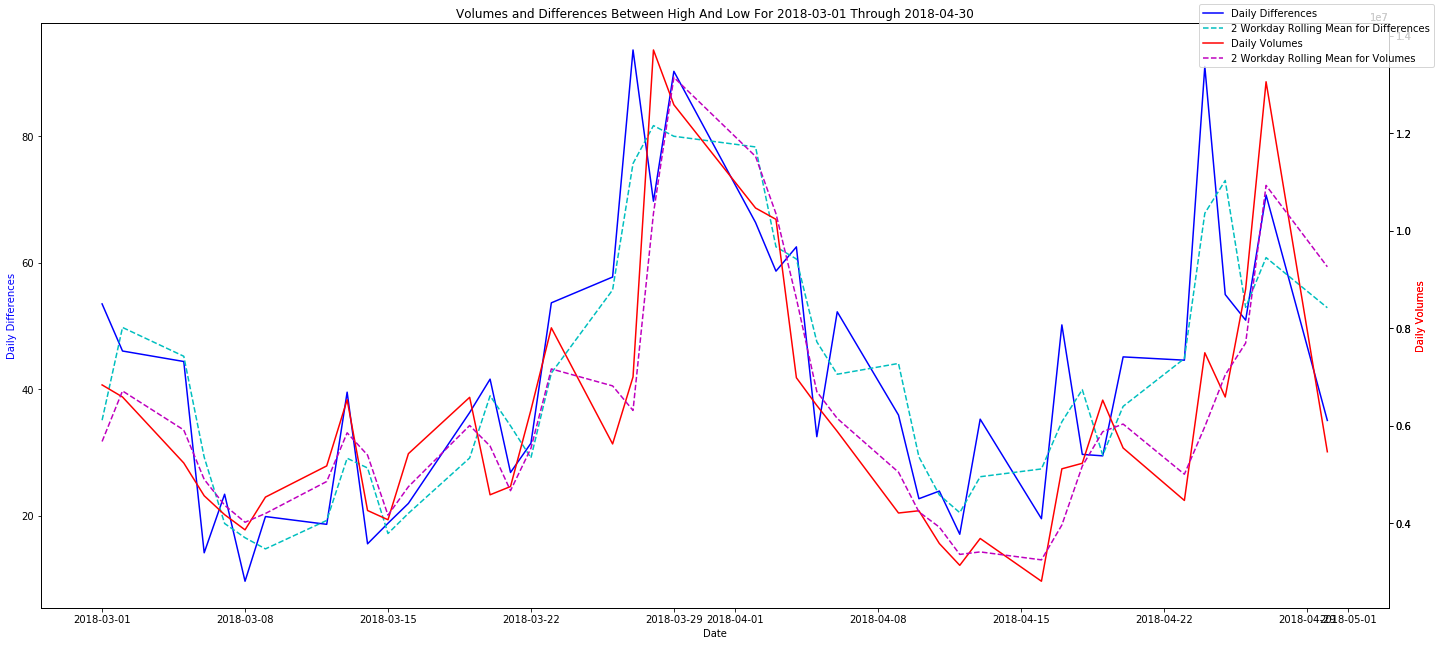

In [29]:
plot_amzn_yr_months_diffs_and_volume('High', 'Low', [1,2018], [4,2018], [1,2], display=[3,2018])

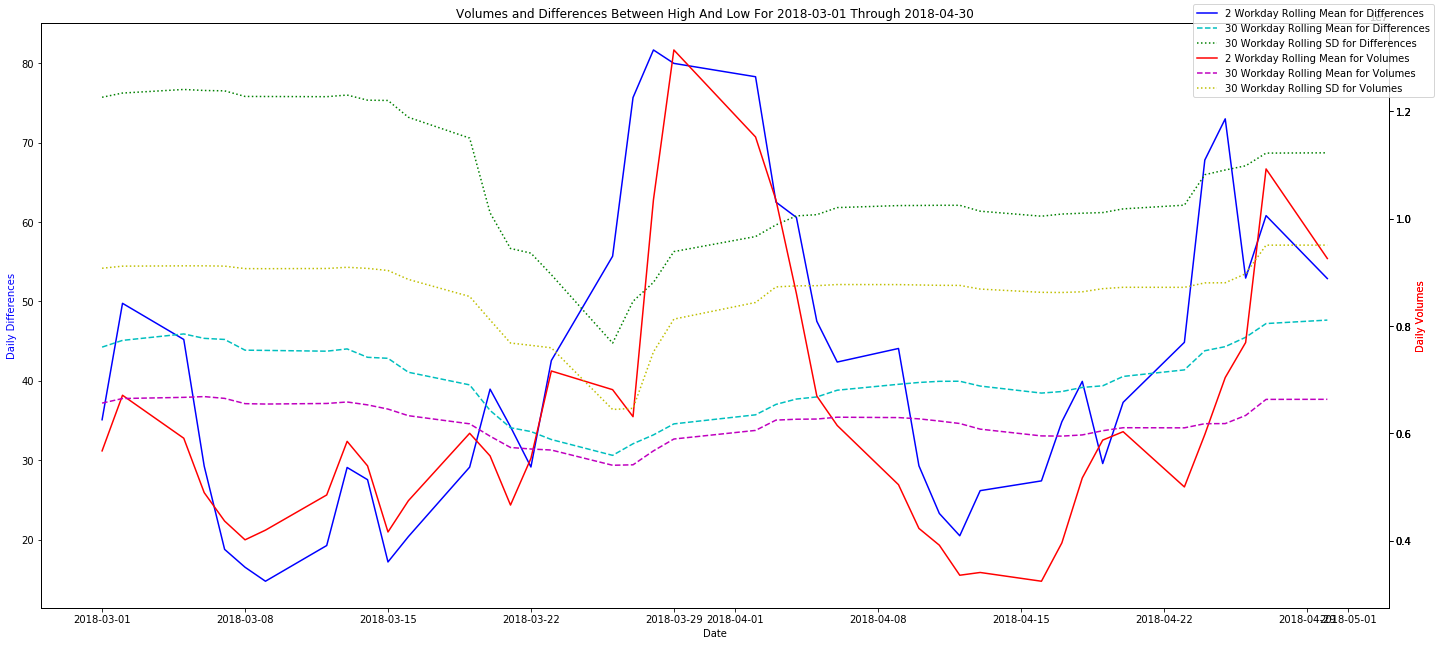

In [33]:
plot_amzn_yr_months_diffs_and_volume('High', 'Low', [1,2018], [4,2018], [2,30], display=[3,2018],sd=True)

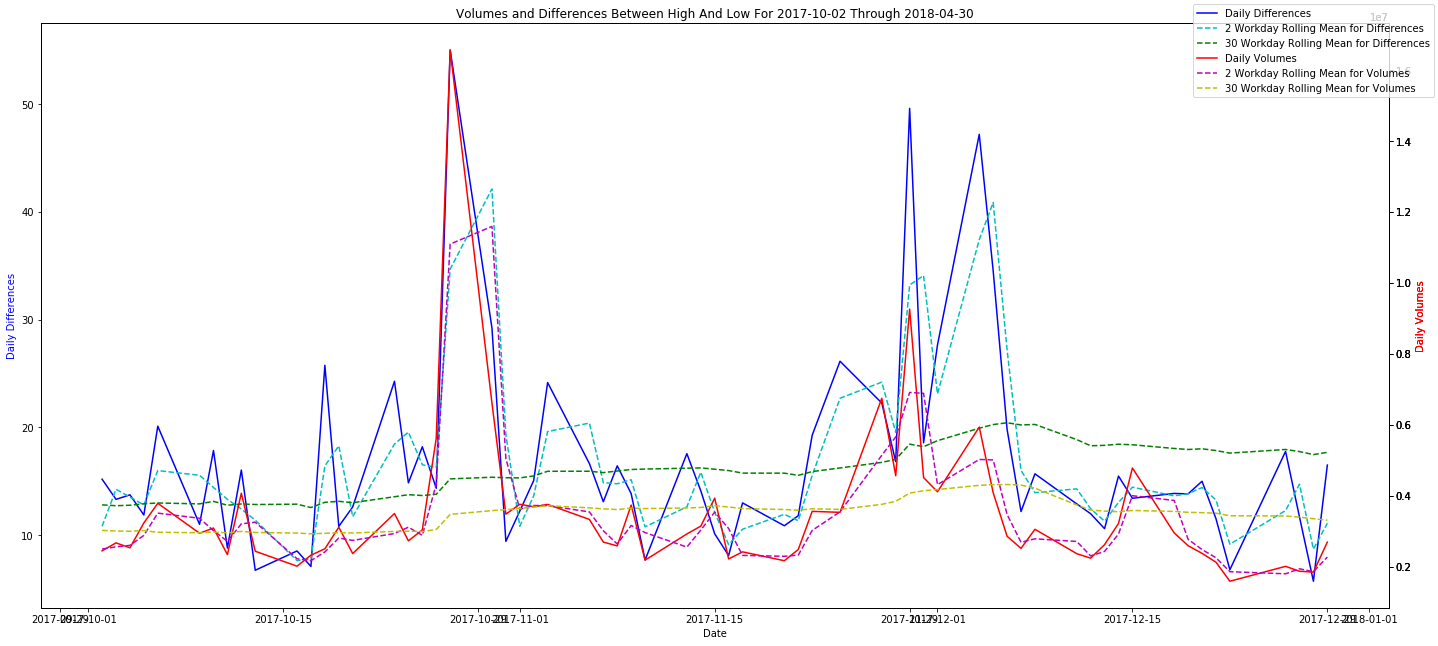

In [20]:
plot_amzn_yr_months_diffs_and_volume('High', 'Low', [8,2017], [4,2018], [1,2,30], display=[10,2017])

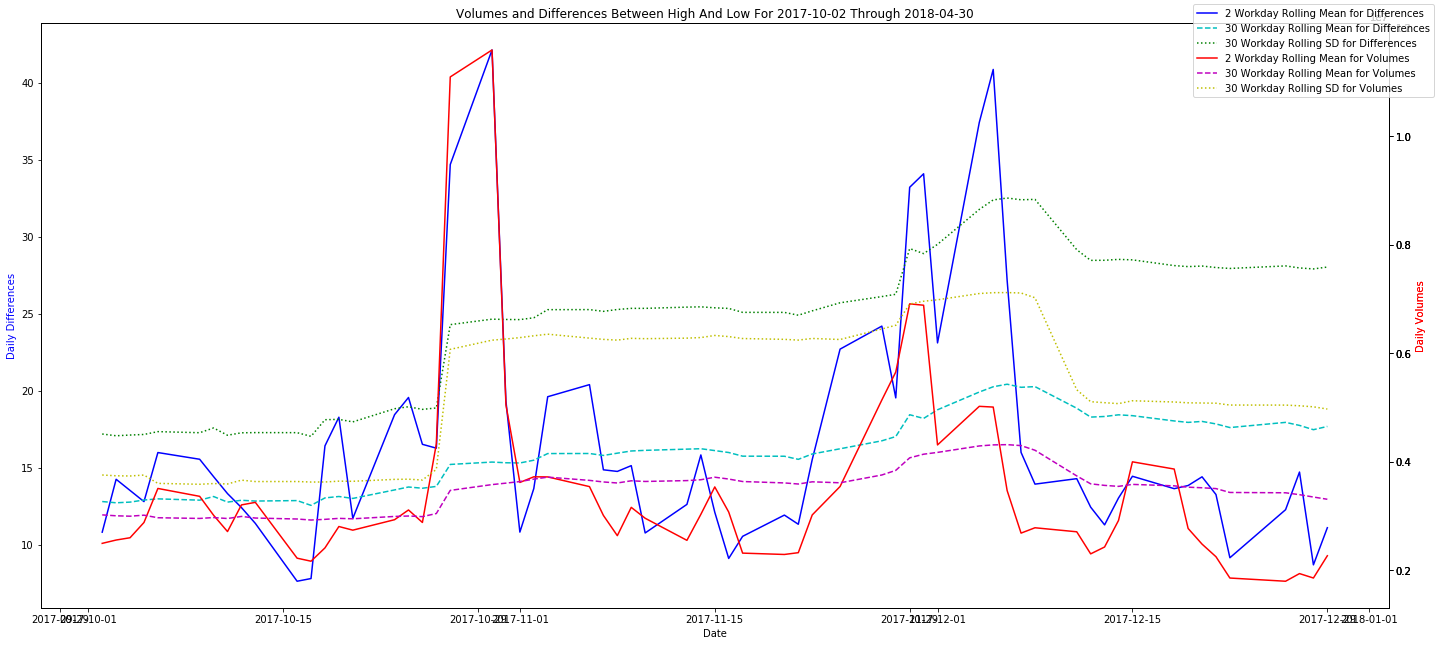

In [21]:
plot_amzn_yr_months_diffs_and_volume('High', 'Low', [8,2017], [4,2018], [2,30], display=[10,2017],sd=True)